In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import netCDF4 as nc

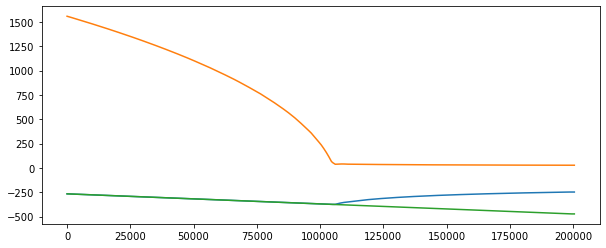

In [2]:
# This code reads in the MISMIP data and crops it to include only the desired region

data = pd.read_csv('/Users/clara.henry/Documents/MISMIP/MISMIP2/DataToInterpolate.csv')
data = data.sort_values(['Points:0', 'Points:1'])
data['Points:0'] = data['Points:0']
data = data.reset_index(drop=True)
data = data.drop(data[(abs(data['Points:0'] - 1050000) > 100000.0)].index)
xi = np.arange(950000,1151000,500)
dataZB = data.drop(data[(data['zb'] == 0.0)].index)
dataZS = data.drop(data[(data['zs'] == 0.0)].index)
dataBedrock = data.drop(data[(data['bedrock'] == 0.0)].index)
interZB = np.interp(xi, dataZB['Points:0'], dataZB['zb'])
interZS = np.interp(xi, dataZS['Points:0'], dataZS['zs'])
interBedrock = np.interp(xi, dataBedrock['Points:0'], dataBedrock['bedrock'])

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(xi-950000, interZB)
ax.plot(xi-950000, interZS)
ax.plot(xi-950000, interBedrock)

In [3]:
dataVel = data.loc[abs(data['Points:0'] - 950000) < 1000]
dataVel

,bedrock,zs,zb,depth,height,velocity:0,velocity:1,velocity:2,Points:0,Points:1,Points:2
1092,-266.16,0.0,-266.16,1823.200,0.000,135.86,-0.14103,0,950050.0,-266.1600,0
1093,-266.16,0.0,0.00,1732.000,91.158,140.59,-0.21171,0,950050.0,-175.0000,0
1094,-266.16,0.0,0.00,1640.800,182.320,144.63,-0.28283,0,950050.0,-83.8390,0
1095,-266.16,0.0,0.00,1549.700,273.470,148.05,-0.35487,0,950050.0,7.3185,0
1096,-266.16,0.0,0.00,1458.500,364.630,150.92,-0.42723,0,950050.0,98.4760,0
1097,-266.16,0.0,0.00,1367.400,455.790,153.30,-0.49969,0,950050.0,189.6300,0
1098,-266.16,0.0,0.00,1276.200,546.950,155.25,-0.57203,0,950050.0,280.7900,0
1099,-266.16,0.0,0.00,1185.100,638.110,156.83,-0.64408,0,950050.0,371.9500,0
1100,-266.16,0.0,0.00,1093.900,729.260,158.09,-0.71575,0,950050.0,463.1100,0
1101,-266.16,0.0,0.00,1002.700,820.420,159.08,-0.78695,0,950050.0,554.2700,0


[ 25.599784   568.2028223  136.32476492]


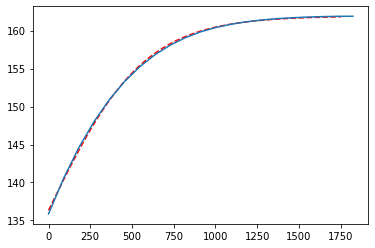

In [4]:
# This code calculates a line of best fit for the velocities on the influx boundary. 

# objective function
def func(x, a, b, c):
    return a * np.tanh(x/b) + c

# fit curve
popt, pcov = curve_fit(func, dataVel['height'], dataVel['velocity:0'], p0=(21,500,135))

a, b, c = popt
print(popt)
x_line = np.arange(0, 1751, 1)
y_line = func(x_line, a, b, c)

plt.plot(x_line, y_line, '--', color='red')
plt.plot(dataVel['height'], dataVel['velocity:0'])

In [ ]:
# This code saves the new data as a netcdf file and also adds a Gaussian bump to create an ice rise.
# This can easily be altered to produce kinks in the ice shelf rather than an ice rise

fn = '/Users/clara.henry/Documents/MISMIP/mmp.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

y = ds.createDimension('y', 121)
x = ds.createDimension('x', 401)

Y = ds.createVariable('y', 'f4', ('y',))
X = ds.createVariable('x', 'f4', ('x',))
Zs = ds.createVariable('zs', 'f4', ('y', 'x',))
Zb = ds.createVariable('zb', 'f4', ('y', 'x',))
Bedrock = ds.createVariable('bedrock', 'f4', ('y', 'x',))

Y[:] = np.arange(-30000, 30500, 500)
X[:] = np.arange(0, 200500, 500)

def AF(y1, x1):
    return 180 * np.exp(-(((x1 - 175000)**2 + (y1)**2)**2)/(2*8000**4))

for i in range(len(X[:])):
    for j in range(len(Y[:])):
        Bedrock[j, i] = interBedrock[i] + AF(Y[j], X[i])

for i in range(len(X[:])):
    for j in range(len(Y[:])):
        if Bedrock[j, i] > interZB[i]:
            Zb[j, i] = Bedrock[j, i]
            Zs[j, i] = interZS[i] + Bedrock[j, i] - interZB[i]
        else:
            Zs[j, i] = interZS[i]
            Zb[j, i] = interZB[i]

ds.close()